### We're gonna do some preprocessing

I am doing this on Casper because I cannot figure out Asha, however I think the directory structure is the same once we navigate to the directory so maybe just start with

In [1]:
machine = 'casper' # 'casper' or 'asha'

I am going to write code that can load in data for a specific model and variable from the training. Maybe a function that can be called to do that.

In [2]:
# I/O / data wrangling
import glob
import numpy as np
import xarray as xr
import gc


In [3]:
if machine == 'casper':
    root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/"
elif machine == 'asha':
    root_dir = "/barnes-scratch/DATA/ForceSMIP/"

In [4]:
cmipTable = {
    "pr": "Amon",
    "psl": "Amon",
    "tas": "Amon",
    "zmta": "Amon",
    "tos": "Omon",
    "siconc": "OImon",
    "monmaxpr": "Aday",
    "monmaxtasmax": "Aday",
    "monmintasmin": "Aday",
}
cmipVar = {
    "pr": "pr",
    "psl": "psl",
    "tas": "tas",
    "zmta": "ta",
    "tos": "tos",
    "siconc": "siconc",
    "monmaxpr": "pr",
    "monmaxtasmax": "tasmax",
    "monmintasmin": "tasmin",
}
evalPeriods = {
    "Tier1": ("1950-01-01", "2022-12-31"),
    "Tier2": ("1900-01-01", "2022-12-31"),
    "Tier3": ("1979-01-01", "2022-12-31"),
}
nlat = 72
nlon = 144

In [5]:
def load_model(model,var,timecut="Tier1",ntrainmems=10):

    filelist = root_dir + "Training/" + cmipTable[var] + "/" + var + "/" + model + "/" + var + "*.nc"
    filelist = glob.glob(filelist)
    filelist = sorted(filelist)

    timebds = evalPeriods[timecut]

    all_ens = []
    for ifile,file in enumerate(filelist[:ntrainmems]):
        ds = xr.open_dataset(file)
        varin = ds[cmipVar[var]]
        varcut = varin.sel(time=slice(timebds[0],timebds[1]))
        varcut = varcut.groupby('time.year').mean()  

        varcut=varcut.assign_coords({"variant":ifile+1})
        all_ens.append(varcut)

    all_ens = xr.concat(all_ens,dim="variant")
    
    return all_ens

In [10]:
def make_X_data(models = ["CESM2","MIROC6","CanESM5"], var = "tos", timecut = "Tier1", nmems = 20):
    nmodels = len(models)

    timebds = evalPeriods[timecut]
    time1 = int(timebds[0][:4])
    time2 = int(timebds[1][:4])

    ntime = time2-time1+1

    X = np.empty((ntime*nmems*nmodels,nlat,nlon))+np.nan

    for imod, model in enumerate(models):

        da=load_model(model,var,timecut,nmems)
        da_np = np.asarray(da)
        Xloop = np.empty((nmems*ntime,nlat,nlon))+np.nan

        for imem in range(nmems):
            Xloop[imem*ntime:(imem+1)*ntime,:,:] = da_np[imem,:,:,:]

        X[nmems*ntime*imod:nmems*ntime*(imod+1),:,:] = Xloop

    Xbad = np.mean(X,axis=0)
    X[:,np.isnan(Xbad)] = 0
    
    return X



In [11]:
X=make_X_data()

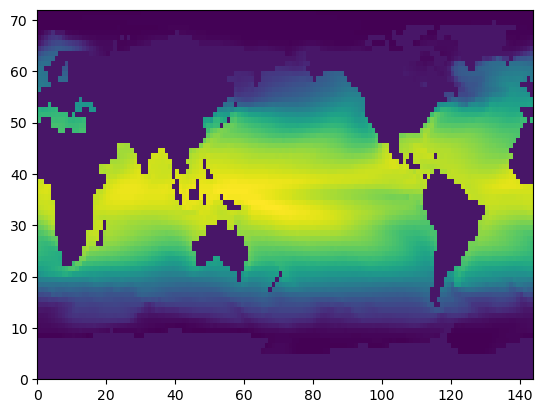

In [12]:
import matplotlib.pyplot as plt
plt.pcolormesh(X[984,:,:])